In [0]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# import os
# os.chdir("gdrive/My Drive/")

In [2]:
import numpy as np
import pandas as pd
import nltk
import re

from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from nltk import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample

from keras.utils import to_categorical

Using TensorFlow backend.


Split Train (0.7) and Test (0.3) Sets

In [0]:
data = pd.read_csv('https://raw.githubusercontent.com/cacoderquan/Sentiment-Analysis-on-the-Rotten-Tomatoes-movie-review-dataset/master/train.tsv', sep="\t")
X_train, X_test, Y_train, Y_test = train_test_split(data['Phrase'], data['Sentiment'], test_size=0.3, random_state=2003)

Data Exploration

In [4]:
Y_train.value_counts()

2    55595
3    23055
1    19203
4     6468
0     4921
Name: Sentiment, dtype: int64

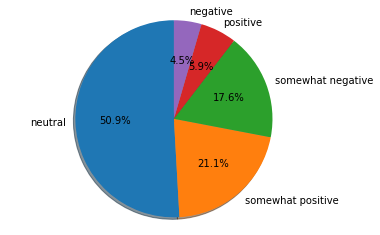

In [5]:
import matplotlib.pyplot as plt

sizes = Y_train.value_counts().values.tolist()
labels = 'neutral', 'somewhat positive', 'somewhat negative', 'positive', 'negative'
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle.
ax1.axis('equal')

plt.show()

In [0]:
X_train = data['Phrase']
Y_train = data['Sentiment']

In [7]:
X_train.head()

0    A series of escapades demonstrating the adage ...
1    A series of escapades demonstrating the adage ...
2                                             A series
3                                                    A
4                                               series
Name: Phrase, dtype: object

In [8]:
X_test.head()

13510                  veteran
61932         many definitions
82549     a worthwhile glimpse
137718       past Seagal films
121990            banal script
Name: Phrase, dtype: object

Setup NLTK

In [9]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

lemma = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Remove Punctuations and Numbers

In [0]:
def remove_punctuations_and_numbers(review):
  # Remove Punctuations and numbers
  filtered_review = re.sub('[^a-zA-Z]',' ',review)
  return filtered_review

Remove Stopwords

In [0]:
def remove_stopwords(review):
  # Remove Stopwords
  word_tokens = word_tokenize(review) 
  filtered_review = [w for w in word_tokens if not w in stop_words]
  filtered_review = ' '.join(filtered_review)
  return filtered_review

Lematizer

In [0]:
def lematize(review):
  filtered_review = [lemma.lemmatize(w) for w in word_tokenize(str(review).lower())]
  filtered_review = ' '.join(filtered_review)
  return filtered_review

Test Preprocessing Functions

In [13]:
test = 'The man is looking at the 2 old brown trees.'
filtered_test_1 = remove_punctuations_and_numbers(test)
filtered_test_2 = remove_stopwords(filtered_test_1)
filtered_test_3 = lematize(filtered_test_2)
print(filtered_test_1)
print(filtered_test_2)
print(filtered_test_3)

The man is looking at the   old brown trees 
The man looking old brown trees
the man looking old brown tree


Preprocess Reviews

In [0]:
def preprecess_reviews(reviews):
  filtered_reviews = []
  for review in reviews:
    filtered_review = remove_punctuations_and_numbers(review)
    filtered_review = remove_stopwords(filtered_review)
    filtered_review = lematize(filtered_review)
    filtered_reviews.append(filtered_review)
  return filtered_reviews

Apply Preprocessing

In [0]:
column_names = ["Filtered_Review", "Sentiment"]
train = pd.DataFrame(columns = column_names)
test = pd.DataFrame(columns = column_names)

# Apply Preprocessing to reviews
train['Filtered_Review'] = preprecess_reviews(X_train.values)
train['Sentiment'] = Y_train
test['Filtered_Review'] = preprecess_reviews(X_test.values)
test['Sentiment'] = Y_test

Data Normalization (Downsampling)

In [0]:
def downsampling(train_0, train_1, train_2, train_3, train_4):

  # returns the number of entries of the smallest class
  MIN_SAMPLES = min(len(train_0), len(train_1), len(train_2), len(train_3), len(train_4))

  train_0_sample = resample(train_0, replace=True, n_samples=MIN_SAMPLES, random_state=2003)
  train_1_sample = resample(train_1, replace=True, n_samples=MIN_SAMPLES, random_state=2003)
  train_2_sample = resample(train_2, replace=True, n_samples=MIN_SAMPLES, random_state=2003)
  train_3_sample = resample(train_3, replace=True, n_samples=MIN_SAMPLES, random_state=2003)
  train_4_sample = resample(train_4, replace=True, n_samples=MIN_SAMPLES, random_state=2003)
  
  df_normalized = pd.concat([train_0_sample, train_1_sample, train_2_sample,train_3_sample, train_4_sample])
  return df_normalized

Data Normalization (Upsampling)

In [0]:
def upsampling(train_0, train_1, train_2, train_3, train_4):

  # returns the number of entries of the largest class
  MAX_SAMPLES = max(len(train_0), len(train_1), len(train_2), len(train_3), len(train_4))

  train_0_sample = resample(train_0, replace=True, n_samples=MAX_SAMPLES, random_state=2003)
  train_1_sample = resample(train_1, replace=True, n_samples=MAX_SAMPLES, random_state=2003)
  train_2_sample = resample(train_2, replace=True, n_samples=MAX_SAMPLES, random_state=2003)
  train_3_sample = resample(train_3, replace=True, n_samples=MAX_SAMPLES, random_state=2003)
  train_4_sample = resample(train_4, replace=True, n_samples=MAX_SAMPLES, random_state=2003)
  
  df_normalized = pd.concat([train_0_sample, train_1_sample, train_2_sample,train_3_sample, train_4_sample])
  return df_normalized

Normalize Data

In [0]:
train_0 = train[train['Sentiment'] == 0]
train_1 = train[train['Sentiment'] == 1]
train_2 = train[train['Sentiment'] == 2]
train_3 = train[train['Sentiment'] == 3]
train_4 = train[train['Sentiment'] == 4]

# df_normalized = downsampling(train_0, train_1, train_2, train_3, train_4)
df_normalized = upsampling(train_0, train_1, train_2, train_3, train_4)

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence,text
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, Flatten, SpatialDropout1D
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import Sequential
from keras.models import load_model

Apply Data Normalization **ONLY** on Train Set **(Not Test Set)**

Labels convert to categorical (One-Hot Encoding)

In [0]:
X_train = df_normalized['Filtered_Review']
Y_train = to_categorical(df_normalized['Sentiment'].values)

# Test set should not normalized!
Y_test = to_categorical(Y_test)

Split Train (0.75) and Validation (0.25) Sets

In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=2003)

Returns Maximum Number of the Words in Reviews

In [0]:
def get_max_review_len(t):
  reviews_len = []
  for review in t:
      token = word_tokenize(review)
      reviews_len.append(len(token))      
  return max(reviews_len)

Returns number of distinct words

In [0]:
def get_num_words(t):
  train_words = ' '.join(t)
  train_words = word_tokenize(train_words)
  dist=FreqDist(train_words)
  return len(dist)

Initialize the Model's Parameters

In [24]:
BATCH_SIZE = 128
EPOCHS = 20
CLASS_NUM = 5

MAX_FEATURES = get_num_words(X_train)
MAX_WORDS = get_max_review_len(X_train)
print(MAX_FEATURES)
print(MAX_WORDS)

13695
31


In [25]:
X_train

90470                                    inspiring ironic
67443                                    first full flush
1908                                   struggle furiously
117329                                 enjoy transparency
141062                               necessary enterprise
                               ...                       
42419                                          delightful
46201                                                    
84623     sewer rat could watch movie skeeved need shower
21827                                      special effect
44067                                       better payoff
Name: Filtered_Review, Length: 298432, dtype: object

In [0]:
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(test['Filtered_Review'])
# X_test

Add Padding to the Dataset for to make the Model Input Sizes same as each other

In [0]:
def add_padding_to_seq(dataset):
  return sequence.pad_sequences(dataset, maxlen=MAX_WORDS)

X_train = add_padding_to_seq(X_train)
X_val = add_padding_to_seq(X_val)
X_test = add_padding_to_seq(X_test)

Initialize the CNN Model

In [28]:
model = Sequential()

# Input Layer
model.add(Embedding(MAX_FEATURES, 150, input_length=MAX_WORDS))

# CNN
model.add(SpatialDropout1D(0.5))

model.add(Conv1D(128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

# Output layer
model.add(Dense(CLASS_NUM, activation='softmax'))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Initilize evaluation metrics

Recall, Precision, F1-Score

In [0]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Train the Model using the Training and Validation Dataset

In [30]:
model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['acc', f1_m, precision_m, recall_m])
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

score, acc, f1, prec, recall = model.evaluate(X_test, Y_test, verbose=1)
print('Score = ' + str(score))
print('Accuracy = ' + str(acc))



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 298432 samples, validate on 99478 samples
Epoch 1/20





298432/298432 [==============================] - 26s 88us/step - loss: 0.8878 - acc: 0.6377 - f1_m: 0.5891 - precision_m: 0.6992 - recall_m: 0.5201 - val_loss: 0.6990 - val_acc: 0.7213 - val_f1_m: 0.7055 - val_precision_m: 0.7639 - val_recall_m: 0.6557
Epoch 2/20
298432/298432 [==============================] - 24s 80us/step - loss: 0.6793 - acc: 0.7327 - f1_m: 0.7220 - precision_m: 0.7683 - recall_m: 0.6814 - val_loss: 0.6305 - val_acc: 0.7558 - val_f1_m: 0.7472 - val_precision_m: 0.7854 - val_recall_m: 0.7127
Epoch 3/20
298432/298432 [==============================] - 24s 79us/step - loss: 0.6193 - acc: 0.7580 - f1_m: 0.7505 - precision_m: 0.7872 - recall_m: 0.7174 - val_loss: 0.6084 - val_acc: 0.7685 - val_f1_m: 0.7631 - val_precision_m: 0.7951 - val_recall_m: 0.7338
Epoch 4/20
298432/298432 [===========================

Plot Loss and Accuracy on Training Phase

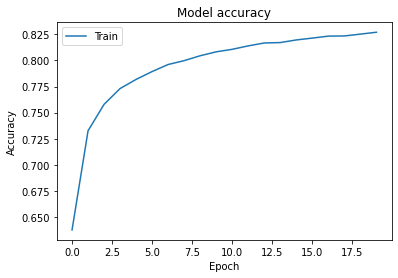

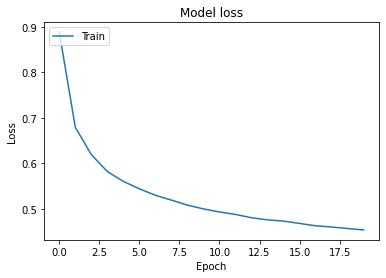

In [31]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

Save the Model for further use

In [0]:
MODEL_FILE_NAME = "1114548_1dconv_reg"
model.save(MODEL_FILE_NAME)

Evaluate the Model using Testing dataset

In [33]:
dependencies = {
     'f1_m': f1_m,
     'precision_m': precision_m,
     'recall_m': recall_m
}

model = load_model(MODEL_FILE_NAME, custom_objects=dependencies)
score, acc, f1, prec, recall = model.evaluate(X_test, Y_test, verbose=1)

print('Score = ' + str(score))
print('Accuracy = ' + str(acc))
print('F1 = ' + str(f1))
print("Precision = " + str(prec))
print("Recall = " + str(recall))

46818/46818 [==============================] - 3s 66us/step
Score = 0.7480435590985605
Accuracy = 0.7500533982656243
F1 = 0.7444211079307488
Precision = 0.7661005431245345
Recall = 0.7245717459096929
